# Text Classification Logistic Regression

In [13]:
import os
import pandas as pd
import numpy as np
import re
import json
# import nltk
# from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LogisticRegression
# from mlflow.logi
import seaborn as sns

In [14]:
data = pd.read_csv('/home/coochie/vscode/ml-ops/data/phishing/email_data.csv')
data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [15]:
num_rows = data.shape[0]
num_cols = data.shape[1]

id2label = {0: "Not-Spam", 1: "Spam"}
label2id = {"Not-Spam": 0, "Spam": 1}
print(f"\nDataFrame Shape:\n  Rows: {num_rows}\n  Columns: {num_cols}")

print("\nColumn Names:")
column_names = list(data.columns)
print('  ',", ".join([str(col) for col in column_names]))

print("\nNumber of Unique Classes:")
unique_classes = sorted(list(set(data["label"].tolist())))
num_classes = len(unique_classes)
print('  ',f"{num_classes}")

print("\nList of Unique Classes:")
for index, class_name in enumerate(unique_classes):
    print('  ',f"{class_name} = {id2label[class_name]}")



DataFrame Shape:
  Rows: 39154
  Columns: 7

Column Names:
   sender, receiver, date, subject, body, label, urls

Number of Unique Classes:
   2

List of Unique Classes:
   0 = Not-Spam
   1 = Spam


In [16]:
row = 444


print(json.dumps(
    {
        'body': data['body'][row],
        'label': str(data['label'][row])
    }, indent=4))

{
    "body": "\nTake your love life to the next level\nhttp://www.brightdone.com\n\n--\nUsing Opera's revolutionary e-mail client: http://www.opera.com/mail/\n\n\n",
    "label": "1"
}


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sender    39154 non-null  object
 1   receiver  38692 non-null  object
 2   date      39154 non-null  object
 3   subject   39126 non-null  object
 4   body      39154 non-null  object
 5   label     39154 non-null  int64 
 6   urls      39154 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.1+ MB


In [18]:
data.describe()

,label,urls
count,39154.000000,39154.00000
mean,0.557848,0.66997
std,0.496649,0.47023
min,0.000000,0.00000
25%,0.000000,0.00000
50%,1.000000,1.00000
75%,1.000000,1.00000
max,1.000000,1.00000


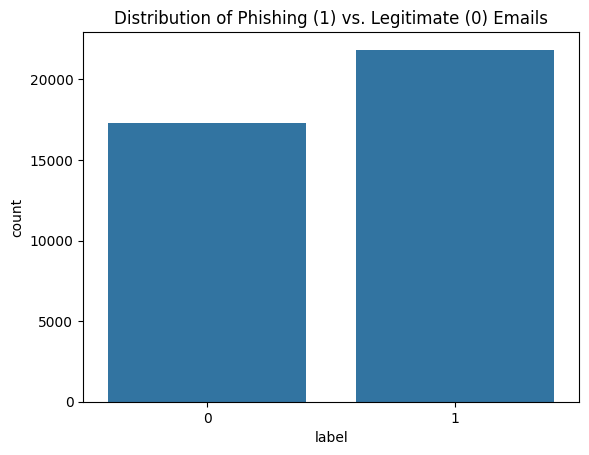

In [19]:
# Distribution of the label column
sns.countplot(x='label', data=data)
plt.title('Distribution of Phishing (1) vs. Legitimate (0) Emails')
plt.show()

In [7]:
# %%time
# # preprocessing functions
# stop_words = set(stopwords.words('english'))

def text_preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('@\w+\s*', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('http', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]', '', text)
    return text

# def drop_stopwords(text):
#     dropped = [word for word in text.split() if word not in stop_words]
#     final_text = ' '.join(dropped)
#     return final_text


def delete_one_characters(text):
    deleted = [word if len(word)>1 else "" for word in text.split()]
    final_text = ' '.join(deleted)
    return final_text


# applying preprocessing functions 
data['body'] = data['body'].apply(text_preprocessing).apply(delete_one_characters)

In [8]:
# final dataframe
data.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,buck up your troubles caused by small dimensio...,1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,upgrade your sex and pleasures with these tech...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,the daily top from cnn com top videos and stor...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,would anyone object to removing so from this l...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,welcomefastshippingcustomersupport blu livefil...,1,1


In [10]:
# train,validation and test splitting

train_val_data, test_data = train_test_split(data, test_size = 0.13, random_state = 42, stratify = data['label'])
train_data, val_data = train_test_split(train_val_data, test_size = 0.15, random_state =42, stratify = train_val_data['label'])


train_data.reset_index(drop = True, inplace = True)
val_data.reset_index(drop = True, inplace = True)
test_data.reset_index(drop = True, inplace = True)

print('train samples :\t', train_data.shape[0])
print('val samples :\t', val_data.shape[0])
print('test samples :\t', test_data.shape[0])

train samples :	 28953
val samples :	 5110
test samples :	 5091


In [12]:
%%time
# Creating pipeline
log_reg = make_pipeline(TfidfVectorizer(), LogisticRegression(C=5.0, max_iter = 200))
log_reg.fit(train_data['body'].values, train_data['label'].values)

CPU times: user 45.8 s, sys: 10.5 s, total: 56.3 s
Wall time: 7.19 s


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression',
                 LogisticRegression(C=5.0, max_iter=200))])

In [16]:
def plot_prediction_results(y_true: np.array, y_pred : np.array) -> None:
    
    mse = mean_squared_error(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average = 'weighted')
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    clf = classification_report(y_true, y_pred, target_names = ['non-spam', 'spam'])
    
    print('Mean Squared Error :\t{0:.5f}'.format(mse))
    print('Weighted F1 Score :\t{0:.3f}'.format(f1))
    print('Accuracy Score :\t{0:.3f} %'.format(acc*100))
    print('--'*35)
    
    print('\n Classification Report:\n',clf)
    print('--'*35)

    print('\n Confusion Matrix: \n')

    cmd = ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels = ['non-spam', 'spam'],  xticks_rotation="vertical", values_format = '2g', colorbar = False)

Mean Squared Error :	0.00530
Weighted F1 Score :	0.995
Accuracy Score :	99.470 %
----------------------------------------------------------------------

 Classification Report:
               precision    recall  f1-score   support

    non-spam       0.99      1.00      0.99      2242
        spam       1.00      0.99      1.00      2849

    accuracy                           0.99      5091
   macro avg       0.99      0.99      0.99      5091
weighted avg       0.99      0.99      0.99      5091

----------------------------------------------------------------------

 Confusion Matrix: 



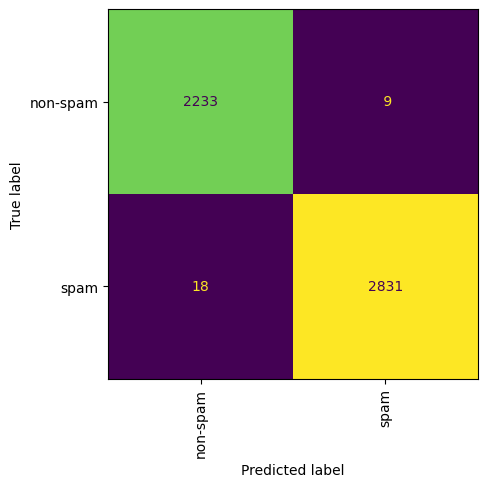

In [17]:
test_pred_log_reg = log_reg.predict(test_data['body'])
plot_prediction_results(test_pred_log_reg, test_data['label'].values)